In [185]:
# necessary libraries

from pmdarima.datasets import load_airpassengers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from merlion.models.utils.autosarima_utils import nsdiffs
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")

In [186]:
data_monthly = pd.read_csv("Airlines+Data.csv")
date = pd.date_range("01-01-1949", periods=len(data_monthly), freq="M")

In [187]:
data_monthly["Month"] = date
data_monthly.set_index("Month", inplace=True)
data_monthly

,Passengers
Month,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1956-08-31,405
1956-09-30,355
1956-10-31,306


## EDA

In [188]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 1949-01-31 to 1956-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


In [189]:
data_monthly.isnull().sum()

Passengers    0
dtype: int64

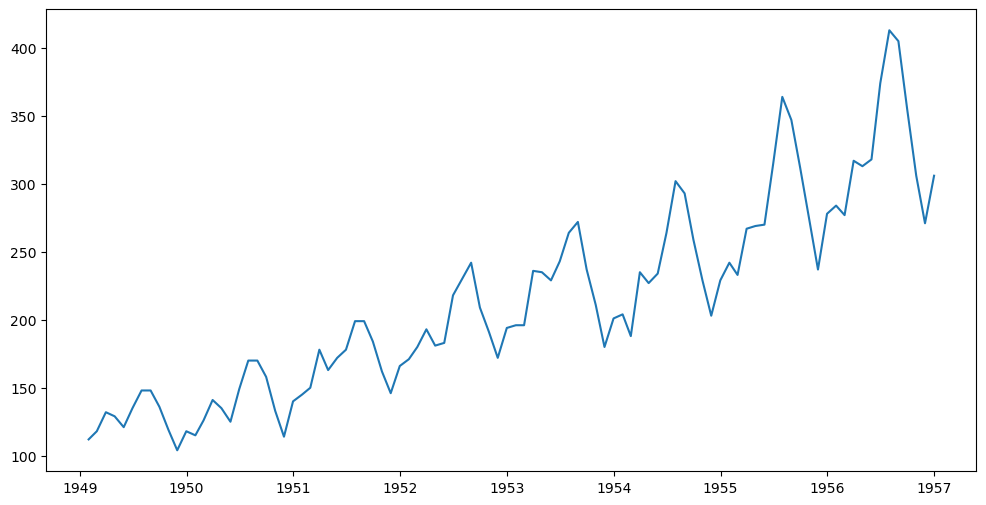

In [190]:
plt.figure(figsize=(12,6))
plt.plot(data_monthly)
plt.show()

In [191]:
data_quarter = data_monthly.resample("Q").sum()
data_anual = data_monthly.resample("A").sum()

# Printing the original monthly data, quarterly data, and annual data
print("Monthly Data:")
print(data_monthly)
print("\nQuarterly Data:")
print(data_quarter)
print("\nAnnual Data:")
print(data_anual)


Monthly Data:
            Passengers
Month                 
1949-01-31         112
1949-02-28         118
1949-03-31         132
1949-04-30         129
1949-05-31         121
...                ...
1956-08-31         405
1956-09-30         355
1956-10-31         306
1956-11-30         271
1956-12-31         306

[96 rows x 1 columns]

Quarterly Data:
            Passengers
Month                 
1949-03-31         362
1949-06-30         385
1949-09-30         432
1949-12-31         341
1950-03-31         382
1950-06-30         409
1950-09-30         498
1950-12-31         387
1951-03-31         473
1951-06-30         513
1951-09-30         582
1951-12-31         474
1952-03-31         544
1952-06-30         582
1952-09-30         681
1952-12-31         557
1953-03-31         628
1953-06-30         707
1953-09-30         773
1953-12-31         592
1954-03-31         627
1954-06-30         725
1954-09-30         854
1954-12-31         661
1955-03-31         742
1955-06-30         854
195

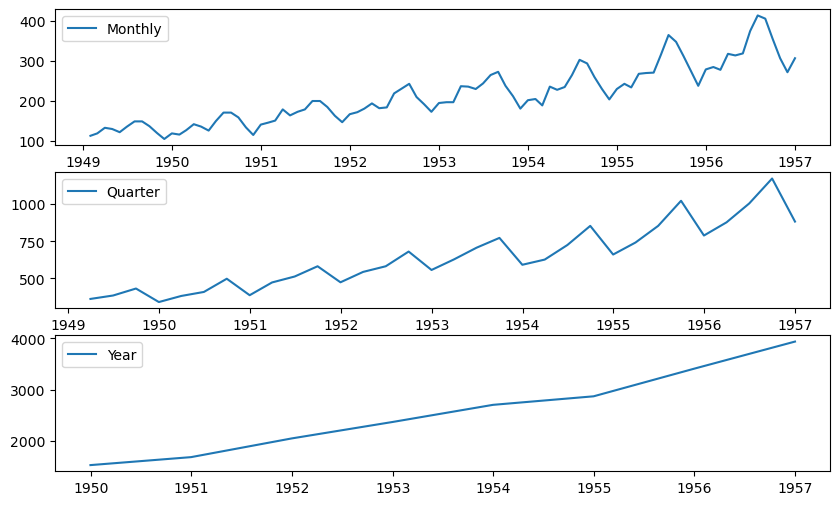

In [192]:
# Creating subplots for monthly, quarterly, and annual data
fig, ax = plt.subplots(3, 1, figsize=(10, 6))

ax[0].plot(data_monthly, label="Monthly")
ax[0].legend(loc=0)

ax[1].plot(data_quarter, label="Quarter")
ax[1].legend(loc=0)

ax[2].plot(data_anual, label="Year")
ax[2].legend(loc=0)

plt.show()

In [193]:
data_monthly["Months"] = data_monthly.index.month
data_monthly["Years"] = data_monthly.index.year
data_monthly

,Passengers,Months,Years
Month,,,
1949-01-31,112,1,1949
1949-02-28,118,2,1949
1949-03-31,132,3,1949
1949-04-30,129,4,1949
1949-05-31,121,5,1949
...,...,...,...
1956-08-31,405,8,1956
1956-09-30,355,9,1956
1956-10-31,306,10,1956


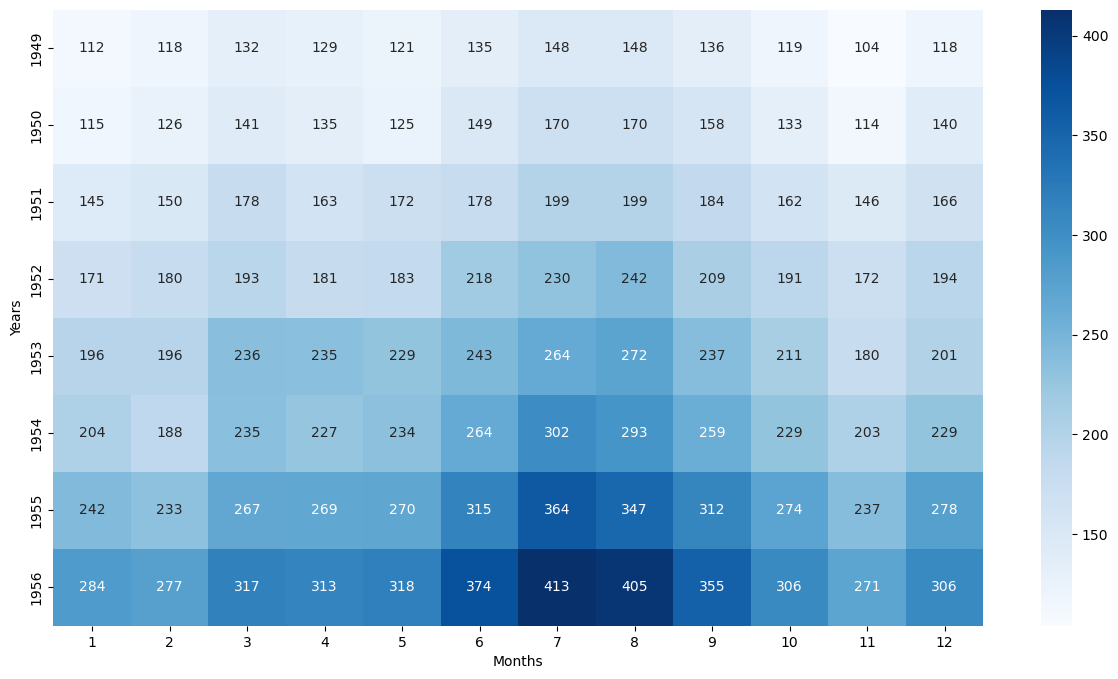

In [194]:
plt.figure(figsize=(15,8))
matrix = pd.pivot_table(data_monthly, values="Passengers", index="Years", columns="Months")
colors = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(matrix, annot=True, fmt="g", cmap=colors)
plt.show()


In [195]:
data_quarter["Months"] = data_quarter.index.month
data_quarter["Years"] = data_quarter.index.year
data_quarter.head()

,Passengers,Months,Years
Month,,,
1949-03-31,362,3,1949
1949-06-30,385,6,1949
1949-09-30,432,9,1949
1949-12-31,341,12,1949
1950-03-31,382,3,1950


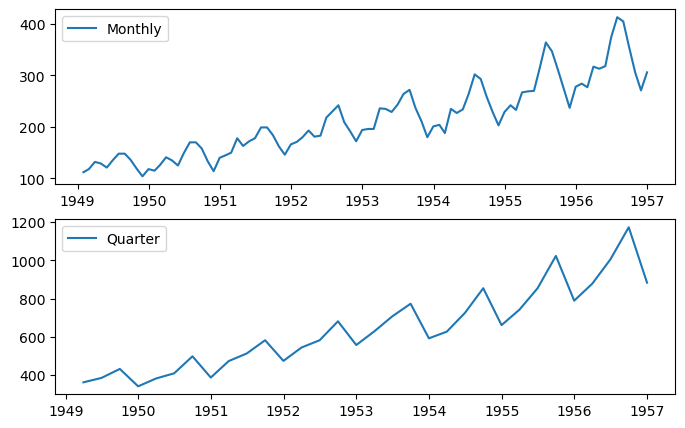

In [196]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].plot(data_monthly["Passengers"], label="Monthly")
ax[0].legend(loc=0)
ax[1].plot(data_quarter["Passengers"], label="Quarter")
ax[1].legend(loc=0)
plt.show()

In [197]:
data_monthly_boxcox, lm_monthly = boxcox(data_monthly["Passengers"])
data_quarter_boxcox, lm_quarter = boxcox(data_quarter["Passengers"])
data_monthly["BoxCox"] = data_monthly_boxcox
data_quarter["BoxCox"] = data_quarter_boxcox
data_monthly

,Passengers,Months,Years,BoxCox
Month,,,,
1949-01-31,112,1,1949,4.543303
1949-02-28,118,2,1949,4.591641
1949-03-31,132,3,1949,4.695356
1949-04-30,129,4,1949,4.674105
1949-05-31,121,5,1949,4.614882
...,...,...,...,...
1956-08-31,405,8,1956,5.722164
1956-09-30,355,9,1956,5.602437
1956-10-31,306,10,1956,5.467173


In [198]:
data_quarter.head()

,Passengers,Months,Years,BoxCox
Month,,,,
1949-03-31,362,3,1949,5.562963
1949-06-30,385,6,1949,5.617786
1949-09-30,432,9,1949,5.720120
1949-12-31,341,12,1949,5.509711
1950-03-31,382,3,1950,5.610827


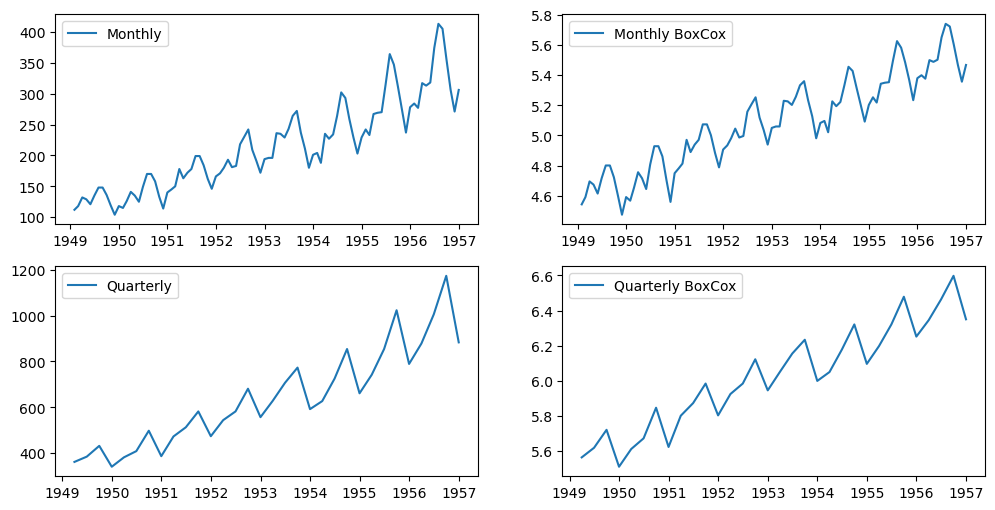

In [199]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(data_monthly["Passengers"], label="Monthly")
ax[0, 0].legend(loc=0)

ax[0, 1].plot(data_monthly["BoxCox"], label="Monthly BoxCox")
ax[0, 1].legend(loc=0)

ax[1, 0].plot(data_quarter["Passengers"], label="Quarterly")
ax[1, 0].legend(loc=0)

ax[1, 1].plot(data_quarter["BoxCox"], label="Quarterly BoxCox")
ax[1, 1].legend(loc=0)

plt.show()

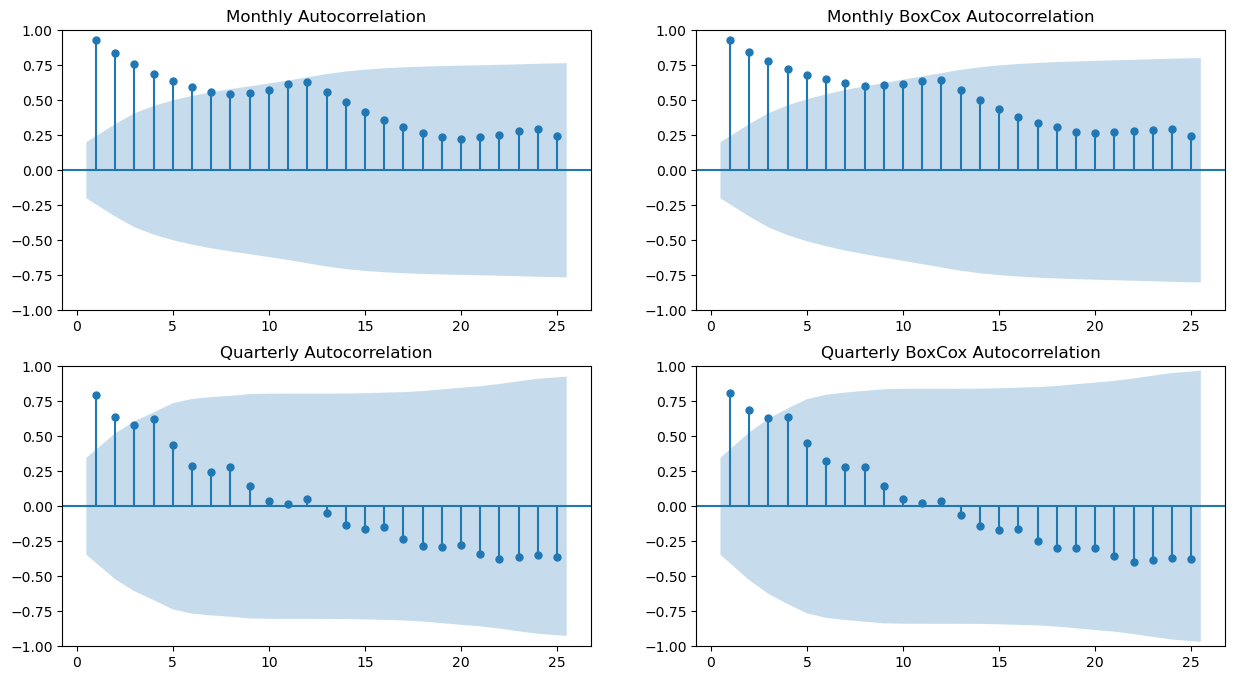

In [200]:
# autocorrelation plots
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

plot_acf(data_monthly["Passengers"], lags=25, zero=False, ax=ax[0, 0])
ax[0, 0].set_title("Monthly Autocorrelation")

# Plotting autocorrelation for monthly data with Box-Cox transformation
plot_acf(data_monthly["BoxCox"], lags=25, zero=False, ax=ax[0, 1])
ax[0, 1].set_title("Monthly BoxCox Autocorrelation")

# Plotting autocorrelation for quarterly data
plot_acf(data_quarter["Passengers"], lags=25, zero=False, ax=ax[1, 0])
ax[1, 0].set_title("Quarterly Autocorrelation")

# Plotting autocorrelation for quarterly data with Box-Cox transformation
plot_acf(data_quarter["BoxCox"], lags=25, zero=False, ax=ax[1, 1])
ax[1, 1].set_title("Quarterly BoxCox Autocorrelation")

# Displaying the plots
plt.show()

In [201]:
data_train = data_monthly["Passengers"].iloc[:-12]
data_test = data_monthly["Passengers"].iloc[-12:]
data_test

Month
1956-01-31    284
1956-02-29    277
1956-03-31    317
1956-04-30    313
1956-05-31    318
1956-06-30    374
1956-07-31    413
1956-08-31    405
1956-09-30    355
1956-10-31    306
1956-11-30    271
1956-12-31    306
Name: Passengers, dtype: int64

In [202]:
# Decomposing the training data into trend, seasonal, and residual components
sd = seasonal_decompose(data_train, model="multiplicative", period=12, extrapolate_trend="freq")

data = pd.concat(
    [sd.observed,
     sd.trend,
     sd.seasonal,
     sd.observed/sd.seasonal], axis=1)

data.columns = ["Original Data", "Trend", "Seasonality", "Seasonal Adjustment"]
data

,Original Data,Trend,Seasonality,Seasonal Adjustment
Month,,,,
1949-01-31,112.0,118.588481,0.913722,122.575560
1949-02-28,118.0,119.734169,0.916766,128.713331
1949-03-31,132.0,120.879856,1.044762,126.344532
1949-04-30,129.0,122.025544,0.997020,129.385542
1949-05-31,121.0,123.171232,0.977856,123.740140
...,...,...,...,...
1955-08-31,347.0,289.261315,1.186484,292.460662
1955-09-30,312.0,293.060849,1.055132,295.697615
1955-10-31,274.0,296.860383,0.919004,298.149013


In [203]:
data_test = pd.DataFrame(data_test)
data_test["Seasonality"] = data["Seasonality"].iloc[:12].values
data_test

,Passengers,Seasonality
Month,,
1956-01-31,284,0.913722
1956-02-29,277,0.916766
1956-03-31,317,1.044762
1956-04-30,313,0.997020
1956-05-31,318,0.977856
1956-06-30,374,1.089263
1956-07-31,413,1.198376
1956-08-31,405,1.186484
1956-09-30,355,1.055132


In [204]:
entry = np.arange(len(data.index) + 1, len(data.index) + 13)
entry

array([85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

#### fitted linear regression model

In [205]:
pred_sm = model_sm.predict(sm.add_constant(entry))
data_test["Predictions"] = (data_test["Seasonality"] * pred_sm).astype(int)
data_test

,Passengers,Seasonality,Predictions
Month,,,
1956-01-31,284,0.913722,264
1956-02-29,277,0.916766,266
1956-03-31,317,1.044762,306
1956-04-30,313,0.997020,294
1956-05-31,318,0.977856,290
1956-06-30,374,1.089263,326
1956-07-31,413,1.198376,361
1956-08-31,405,1.186484,360
1956-09-30,355,1.055132,323


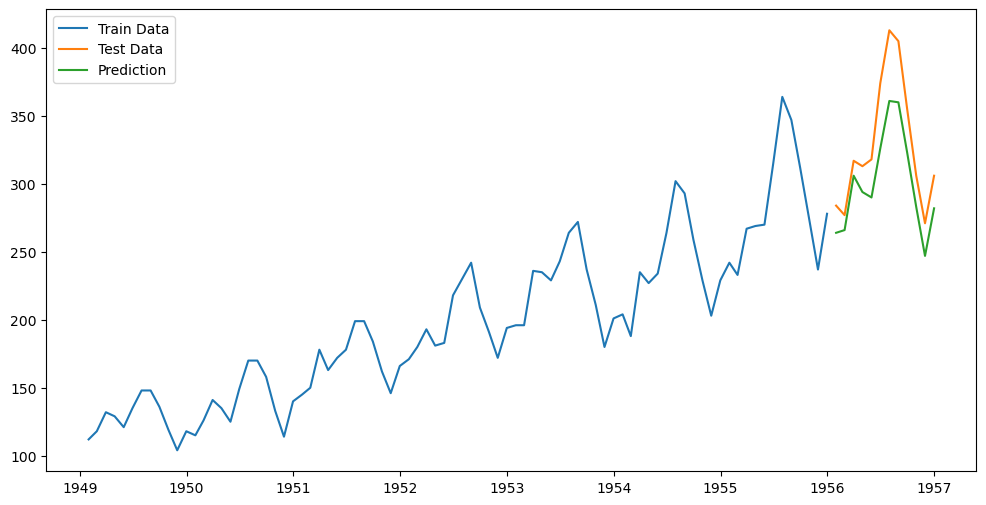

In [206]:
plt.figure(figsize=(12,6))
plt.plot(data["Original Data"], label="Train Data")
plt.plot(data_test["Passengers"], label="Test Data")
plt.plot(data_test["Predictions"], label="Prediction")

plt.legend()

plt.show()

In [207]:
def error(y, pred):
    print("MSE: {}".format(mean_squared_error(y, pred)))
    print("RMSE: {}".format(np.sqrt(mean_squared_error(y, pred))))
    print("MAE: {}".format(mean_absolute_error(y, pred)))

In [208]:
error(data_test["Passengers"], data_test["Predictions"])

MSE: 960.4166666666666
RMSE: 30.990589969645086
MAE: 28.083333333333332


In [211]:
# Defining trend and seasonal types
trend_type = ["add", "mul"]
seasonal_type = ["add", "mul"]

for i in trend_type:
    for j in seasonal_type:
        holtwinter_model = ExponentialSmoothing(data_train, trend=i, seasonal=j, seasonal_periods=12).fit(optimized=True)
        pred_holtwinter = holtwinter_model.forecast(12)
        rmse = np.sqrt(mean_squared_error(data_test["Passengers"], pred_holtwinter))
        print("Trend: {}, Seasonality: {}, RMSE: {}".format(i, j, rmse))

Trend: add, Seasonality: add, RMSE: 29.586908739980256
Trend: add, Seasonality: mul, RMSE: 12.918325889256476
Trend: mul, Seasonality: add, RMSE: 26.051246890654028
Trend: mul, Seasonality: mul, RMSE: 7.756696006117338


#### Holt-Winters Exponential Smoothing model

In [212]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
holtwinter_model = ExponentialSmoothing(data_train, trend="add", seasonal="multiplicative", seasonal_periods=12).fit(optimized=True)
pred_holtwinter = holtwinter_model.forecast(12)
holtwinter_rmse = np.sqrt(mean_squared_error(data_test["Passengers"], pred_holtwinter))
print("RMSE:", holtwinter_rmse)

RMSE: 12.918325889256476


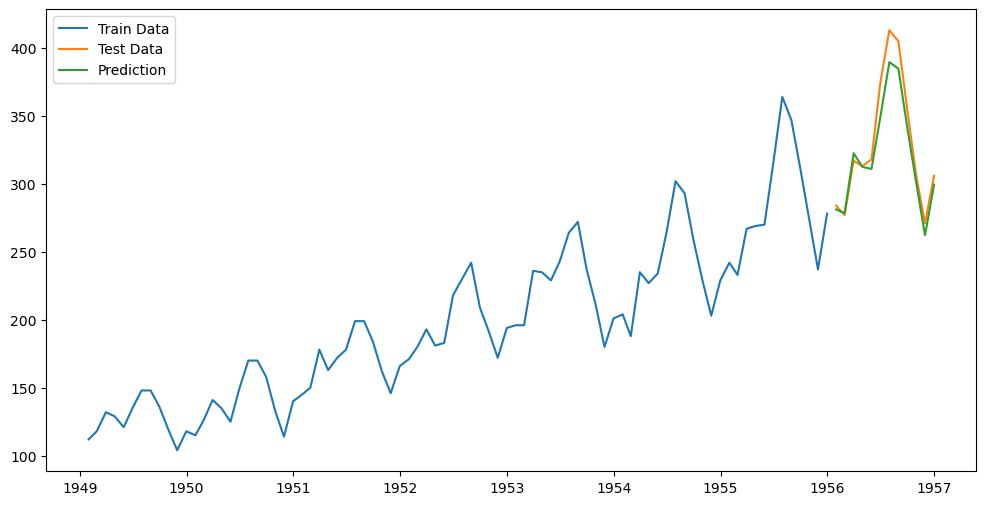

In [213]:
plt.figure(figsize=(12,6))
plt.plot(data_train, label="Train Data")
plt.plot(data_test["Passengers"], label="Test Data")
plt.plot(pred_holtwinter, label="Prediction")
plt.legend()
plt.show()

In [214]:
data_train = pd.DataFrame(data_train)
data_train

,Passengers
Month,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1955-08-31,347
1955-09-30,312
1955-10-31,274


##### Augmented Dickey-Fuller test

In [215]:
adf = ADF(data_train.squeeze(), trend='ct')
print(adf)
print(adf.regression.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.504
P-value                         0.828
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.09 (1%), -3.47 (5%), -3.16 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     21.81
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           1.08e-17
Time:                        22:09:06   Log-Likelihood:                -255.69
No. Observations:                  71   AIC:                             541.4
Df Residuals:                      56   BIC:            

#### KPSS test on the training

In [216]:
kpss_test = KPSS(data_train.squeeze(), trend='ct')
print(kpss_test)

    KPSS Stationarity Test Results   
Test Statistic                  0.037
P-value                         0.770
Lags                                4
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [217]:
data

,Original Data,Trend,Seasonality,Seasonal Adjustment
Month,,,,
1949-01-31,112.0,118.588481,0.913722,122.575560
1949-02-28,118.0,119.734169,0.916766,128.713331
1949-03-31,132.0,120.879856,1.044762,126.344532
1949-04-30,129.0,122.025544,0.997020,129.385542
1949-05-31,121.0,123.171232,0.977856,123.740140
...,...,...,...,...
1955-08-31,347.0,289.261315,1.186484,292.460662
1955-09-30,312.0,293.060849,1.055132,295.697615
1955-10-31,274.0,296.860383,0.919004,298.149013


##### AutoARIMA model to the training

In [218]:
# seasonality
auto_arima_model_1 = auto_arima(data_train["Passengers"], trace=False, seasonal=True, m=12)
pred_auto_arima_1 = auto_arima_model_1.predict(12)
auto_arima_rmse_1 = np.sqrt(mean_squared_error(data_test["Passengers"], pred_auto_arima_1))
print("First AutoARIMA Model's RMSE:", auto_arima_rmse_1)


First AutoARIMA Model's RMSE: 21.04002812747958


In [219]:
data

,Original Data,Trend,Seasonality,Seasonal Adjustment
Month,,,,
1949-01-31,112.0,118.588481,0.913722,122.575560
1949-02-28,118.0,119.734169,0.916766,128.713331
1949-03-31,132.0,120.879856,1.044762,126.344532
1949-04-30,129.0,122.025544,0.997020,129.385542
1949-05-31,121.0,123.171232,0.977856,123.740140
...,...,...,...,...
1955-08-31,347.0,289.261315,1.186484,292.460662
1955-09-30,312.0,293.060849,1.055132,295.697615
1955-10-31,274.0,296.860383,0.919004,298.149013


In [220]:
data_test

,Passengers,Seasonality,Predictions
Month,,,
1956-01-31,284,0.913722,264
1956-02-29,277,0.916766,266
1956-03-31,317,1.044762,306
1956-04-30,313,0.997020,294
1956-05-31,318,0.977856,290
1956-06-30,374,1.089263,326
1956-07-31,413,1.198376,361
1956-08-31,405,1.186484,360
1956-09-30,355,1.055132,323


##### AutoARIMA model to the 'Seasonal Adjustment'

In [221]:
# de-seasonalize
auto_arima_model_2 = auto_arima(data["Seasonal Adjustment"], trace=False, seasonal=False)
pred_auto_arima_2 = auto_arima_model_2.predict(12)
pred_auto_arima_2 = pred_auto_arima_2 * data_test["Seasonality"]
auto_arima_rmse_2 = np.sqrt(mean_squared_error(data_test["Passengers"], pred_auto_arima_2))
print("Second (de-seasonalize) AutoARIMA Model's RMSE:", auto_arima_rmse_2)


Second (de-seasonalize) AutoARIMA Model's RMSE: 14.55004139065431


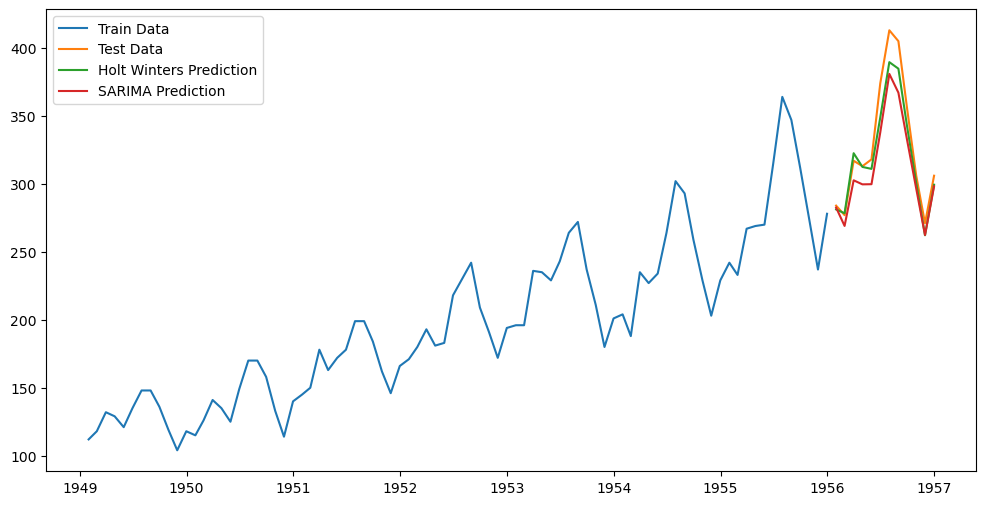

In [222]:
plt.figure(figsize=(12,6))
plt.plot(data_train["Passengers"], label="Train Data")
plt.plot(data_test["Passengers"], label="Test Data")
plt.plot(pred_holtwinter, label="Holt Winters Prediction")
plt.plot(pred_auto_arima_1, label="SARIMA Prediction")
plt.legend()
plt.show()

In [223]:
print("Holt-Winters RMSE:", holtwinter_rmse)
print("AutoARIMA (Model 1) RMSE:", auto_arima_rmse_1)
print("AutoARIMA (Model 2 - de-seasonalize) RMSE:", auto_arima_rmse_2)


Holt-Winters RMSE: 12.918325889256476
AutoARIMA (Model 1) RMSE: 21.04002812747958
AutoARIMA (Model 2 - de-seasonalize) RMSE: 14.55004139065431


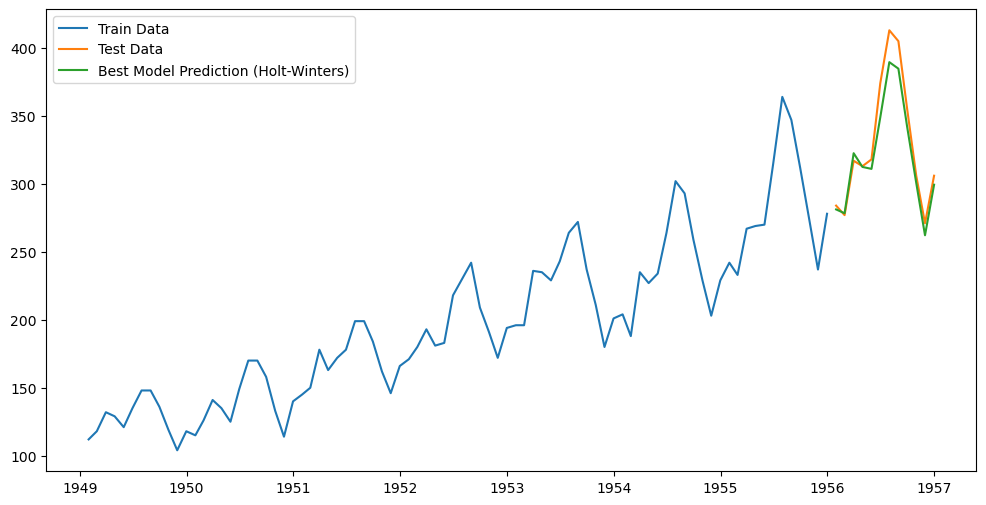

In [224]:
plt.figure(figsize=(12,6))
plt.plot(data_train["Passengers"], label="Train Data")
plt.plot(data_test["Passengers"], label="Test Data")
if holtwinter_rmse == min(holtwinter_rmse, auto_arima_rmse_1, auto_arima_rmse_2):
    plt.plot(pred_holtwinter, label="Best Model Prediction (Holt-Winters)")
elif auto_arima_rmse_1 == min(holtwinter_rmse, auto_arima_rmse_1, auto_arima_rmse_2):
    plt.plot(pred_auto_arima_1, label="Best Model Prediction (AutoARIMA - Model 1)")
else:
    plt.plot(pred_auto_arima_2, label="Best Model Prediction (AutoARIMA - Model 2)")
plt.legend()
plt.show()


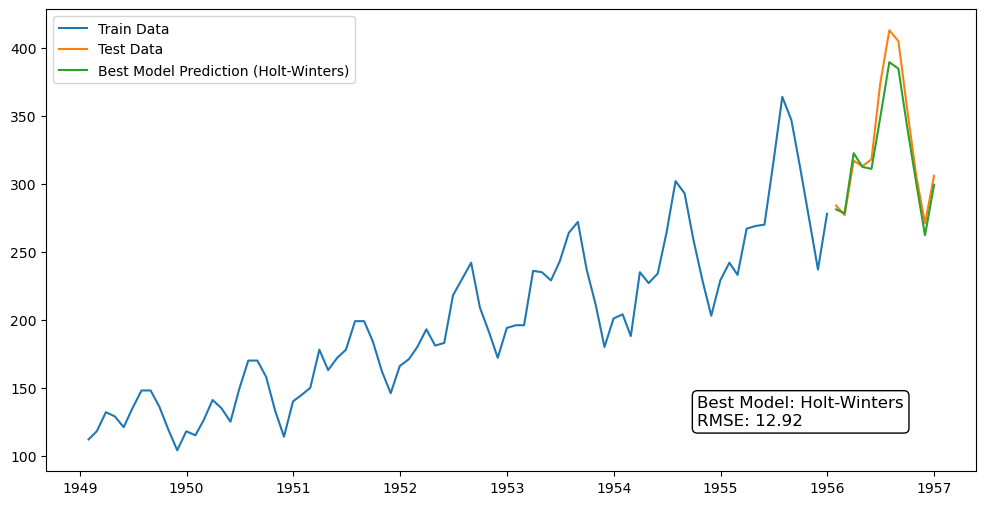

In [225]:
plt.figure(figsize=(12, 6))
plt.plot(data_train["Passengers"], label="Train Data")
plt.plot(data_test["Passengers"], label="Test Data")

models = [
    (pred_holtwinter, "Holt-Winters", holtwinter_rmse),
    (pred_auto_arima_1, "AutoARIMA - Model 1", auto_arima_rmse_1),
    (pred_auto_arima_2, "AutoARIMA - Model 2", auto_arima_rmse_2)
]

best_model, best_name, best_rmse = min(models, key=lambda x: x[2])

plt.plot(best_model, label=f"Best Model Prediction ({best_name})")

plt.annotate(f"Best Model: {best_name}\nRMSE: {best_rmse:.2f}", xy=(0.7, 0.1), xycoords="axes fraction",
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.legend()
plt.show()
